In [1]:
import healpy as hp
import numpy as np
from astropy import units as u
import os
from matplotlib import pyplot as plt
import pymaster as nmt

## Global parameters

In [2]:
nside = 512
ellmax = 3*nside - 1
ells = np.arange(ellmax + 1)
sim_num =32

## 1.Load the mask and calculate fraction of sky

In [3]:
mask_path = '/shared/data/Datasets/I_512_1450_variance_noise/Simulation_Mask/mask.fits'
mask = hp.read_map(mask_path)
fsky = np.sum(mask**2)/len(mask)

Apodize the mask

In [4]:
apod_scale = 2
apod_mask = nmt.mask_apodization(mask, apod_scale, apotype='C2')
fsky_apod = np.sum(apod_mask**2)/len(apod_mask)

In [5]:
def apply_mask(map, mask):
    masked_index = np.where(mask != 1)
    masked_map = map.copy()
    masked_map[masked_index] = hp.UNSEEN
    masked_map = hp.ma(masked_map)
    #masked_map.mask = mask
    return masked_map


## 2. Define common beam used in NILC component separation

In [6]:
def arcmin2rad(arcmin):
    return arcmin * np.pi / 180 / 60

In [7]:
beam_fwhm = 20.6 # arcmin
beam_fwhm = arcmin2rad(beam_fwhm)
beam = hp.gauss_beam(beam_fwhm, lmax=ellmax)

## 3. Estimating power spectrum for an arbitary instance of NILC prediction and fiducal CMB from test set

### (a) Load the maps

In [8]:
#Test set path
fiducial_test_path = '/shared/data/Datasets/I_512_1450_variance_noise/Simulation/Test/'
prediction_test_path = '/shared/data/Datasets/I_512_1450_variance_noise/PyILC_CNILC/NILC_B_Predict/Test/'

In [9]:
# CMB fidual map
cmb_fid_path = fiducial_test_path + f'sim0{sim_num:03d}/cmb_map_fid.fits'

# NILC prediction map
cmb_pred_path = prediction_test_path + f'sim0{sim_num:03d}/cmb_pred.fits'

In [10]:
# CMB fidual map
cmb_fid = hp.read_map(cmb_fid_path)

# NILC prediction map
cmb_pred = hp.read_map(cmb_pred_path)

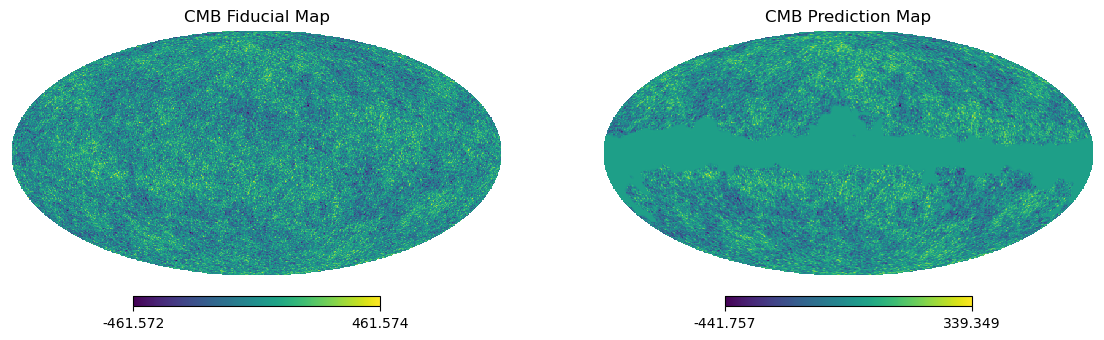

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  

# Left plot: Masked CMB Fiducial Map
plt.sca(axes[0])
hp.mollview(cmb_fid, title='CMB Fiducial Map', hold=True, cbar=True)

# Right plot: Masked CMB Prediction Map
plt.sca(axes[1])
hp.mollview(cmb_pred, title='CMB Prediction Map', hold=True, cbar=True)

plt.subplots_adjust(wspace=0.3, hspace=0)
plt.show()

### (b) Apply mask

Now we deconvolve with the beam first

In [12]:
def beam_deconvol(map_in, beam, nside):
    alm_in = get_alms(map_in)
    alm_out = hp.almxfl(alm_in, 1/beam)
    map_out = hp.alm2map(alm_out, nside)
    return map_out

def get_alms(map_in):
    nside_in = hp.get_nside(map_in)
    lmax_in = 3*nside_in - 1
    alm = hp.map2alm(map_in, lmax = lmax_in)
    return alm

In [13]:
cmb_pred = beam_deconvol(cmb_pred, beam, nside)

In [14]:
# Masked fiducial map
cmb_fid_masked = apply_mask(cmb_fid,apod_mask)

# Masked prediction map
cmb_pred_masked = apply_mask(cmb_pred,apod_mask)

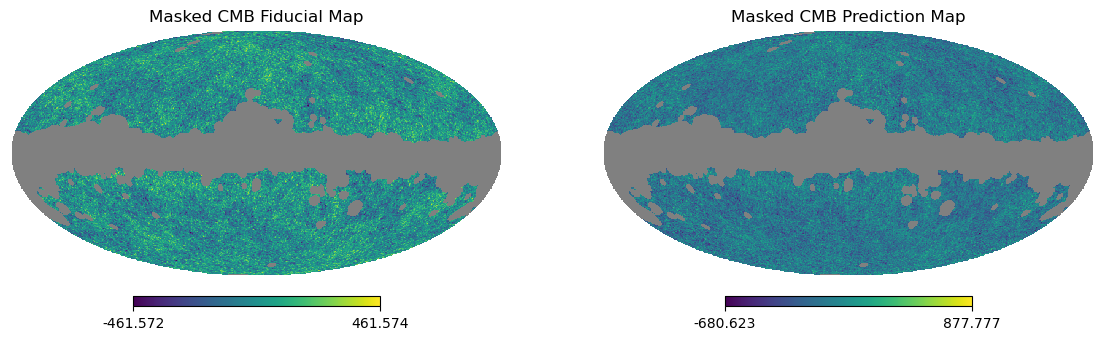

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Masked CMB Fiducial Map
plt.sca(axes[0])
hp.mollview(cmb_fid_masked, title='Masked CMB Fiducial Map', hold=True, cbar=True)

# Right plot: Masked CMB Prediction Map
plt.sca(axes[1])
hp.mollview(cmb_pred_masked, title='Masked CMB Prediction Map', hold=True, cbar=True)

plt.subplots_adjust(wspace=0.3, hspace=0)
plt.show()

### (c) Calculate power spectrum for masked maps and correct for sky fraction

In [16]:
def compute_power_spectrum(map1, ellmax, map2 = None, fsky = None):
    if map2 is not None:
        cl = hp.anafast(map1, map2, lmax= ellmax)
    else:
        cl = hp.anafast(map1, lmax= ellmax)
    if fsky is not None:
        cl /= fsky
    return cl

In [18]:
cl_fid = compute_power_spectrum(cmb_fid_masked, ellmax, fsky = fsky_apod)

cl_pred = compute_power_spectrum(cmb_pred_masked, ellmax, fsky = fsky_apod)

cl_diff = compute_power_spectrum(cmb_pred_masked - cmb_fid_masked, ellmax, fsky = fsky_apod)

### (d) Deconvolve the common beam adapted in component separation

In [17]:
cl_pred_beam = cl_pred/ beam**2

### (e) Normalize the powe spectrum

In [19]:
def normalize_cl(cl):
    return cl *(ells * (ells + 1))/ (2*np.pi )

In [20]:
dl_fid = normalize_cl(cl_fid)

dl_pred_beam = normalize_cl(cl_pred)

dl_diff = normalize_cl(cl_diff)

### (f) Visualize the power spectrum

In [21]:
def plot_power_spectrum(ells, dls, labels, title, ymax=None, xlabel=None, ylabel=None, linewidth=None, alpha=None):
    ymax = ymax if ymax is not None else 1e4
    xlabel = xlabel if xlabel is not None else r'$\ell$'
    ylabel = ylabel if ylabel is not None else r'$D_{\ell}$'
    linewidth = linewidth if linewidth is not None else .5
    alpha = alpha if alpha is not None else .5

    plt.figure(figsize=(8, 6))
    for dl, label in zip(dls, labels):
        plt.plot(ells, dl, label='Power Spectrum for ' + label, linewidth=linewidth, alpha=alpha)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.ylim(0, ymax)
    plt.legend()
    plt.show()

In [22]:
def scatter_plot_power_spectrum(ells, dls, labels, title, s = None, ymax=None, xlabel=None, ylabel=None, linewidth=None, alpha=None):
    s = s if s is not None else 1
    ymax = ymax if ymax is not None else 1e4
    xlabel = xlabel if xlabel is not None else r'$\ell$'
    ylabel = ylabel if ylabel is not None else r'$D_{\ell}$'
    linewidth = linewidth if linewidth is not None else .5
    alpha = alpha if alpha is not None else .5

    plt.figure(figsize=(8, 6))
    for dl, label in zip(dls, labels):
        plt.scatter(ells, dl, s= s,label='Power Spectrum for ' + label, linewidth=linewidth, alpha=alpha)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.ylim(0, ymax)
    plt.legend()
    plt.show()

In [23]:
def combined_power_spectrum_plot(ells, dls_line, dls_scatter, labels_line, labels_scatter, 
                                 title, ymax=None, linewidth=None, alpha=None, s = None,colors_line=None, colors_scatter=None):
    s = s if s is not None else 2
    ymax = ymax if ymax is not None else 1e4
    linewidth = linewidth if linewidth is not None else 1.5
    alpha = alpha if alpha is not None else 1.0
    colors_line = colors_line if colors_line is not None else ['tab:blue', 'tab:green', 'tab:red']
    colors_scatter = colors_scatter if colors_scatter is not None else ['tab:orange', 'tab:purple', 'tab:brown']

    plt.figure(figsize=(8, 6))
    
    # Line Plots
    for dl, label, color in zip(dls_line, labels_line, colors_line):
        plt.plot(ells, dl, label=f'Power Spectrum for {label}', linewidth=linewidth, alpha=alpha, color=color)
    
    # Scatter Plots
    for dl, label, color in zip(dls_scatter, labels_scatter, colors_scatter):
        plt.scatter(ells, dl, label=f'Power Spectrum for {label}', s=s, alpha=alpha, color=color)
    
    plt.xlabel(r'$\ell$')
    plt.ylabel(r'$D_{\ell}$')
    plt.title(title)
    plt.ylim(0, ymax)
    plt.legend()
    plt.show()

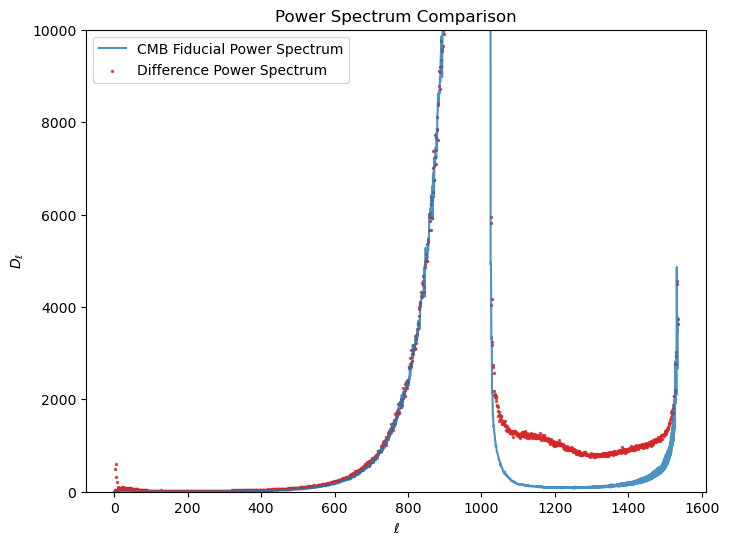

In [34]:
plt.figure(figsize=(8, 6))
plt.plot(ells, dl_noise_pred_avg, label='CMB Fiducial Power Spectrum', linewidth=1.5, alpha=0.8, color='tab:blue')
#plt.plot(ells, dl_pred_beam, label='CMB Prediction Power Spectrum', linewidth=1.5, alpha=0.8, color='tab:orange')
plt.scatter(ells, dl_diff, label='Difference Power Spectrum', s=2, alpha=0.8, color='tab:red')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$D_{\ell}$')
plt.title('Power Spectrum Comparison')
plt.ylim(0, 1e4)
plt.legend()
plt.show()

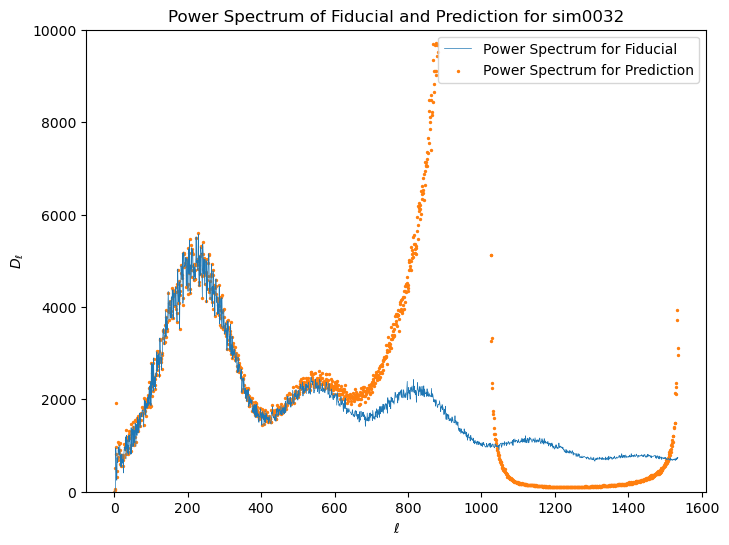

In [25]:
combined_power_spectrum_plot(
    ells=ells,
    dls_line=[dl_fid],
    dls_scatter=[dl_pred_beam],
    labels_line=['Fiducial'],
    labels_scatter=['Prediction'],
    title=f"Power Spectrum of Fiducial and Prediction for sim{sim_num:04d}",
    linewidth=0.5,
    alpha=1,
    s = 2
)

## 4. Estimate bias introduced by instrumental noise

### (a) Load 100 realisations of weighted noise maps

In [27]:
noise_res_dir = '/home/yunan/pyilc/output/noise_res/' 

In [28]:
cl_noise_preds = []
for i in range(100):
    noise_res_fn = noise_res_dir + f'sim{sim_num:03d}/CN_needletILCmap_component_CMB_noise_res.fits'
    noise_res = hp.read_map(noise_res_fn)
    noise_res = beam_deconvol(noise_res, beam, nside)
    noise_res_masked = apply_mask(noise_res, apod_mask)
    cl_noise_res = compute_power_spectrum(noise_res_masked, ellmax, fsky = fsky_apod)
    cl_noise_preds.append(cl_noise_res)

### (b) Deconvolve the beam and normalize

In [29]:
dl_noise_preds = []
for cl_noise_pred in cl_noise_preds:
    cl_noise_pred_beam = cl_noise_pred
    dl_noise_pred_beam = ells * (ells + 1) * cl_noise_pred_beam / 2 / np.pi
    dl_noise_preds.append(dl_noise_pred_beam)

### (c) Take the average of the 100 realizations and save to output

In [30]:
dl_noise_pred_avg = np.mean(dl_noise_preds, axis=0)

In [28]:
output_dir = '/home/yunan/pyilc/output/noise_res/'
output_fn = output_dir + f'Averaged_CMB_noise_res.npy'
with open(output_fn, 'wb') as f:
    np.save(f, dl_noise_pred_avg)

### (d) Visualize the noise bias

Not much scattering, averaing is flatten most of the deviations

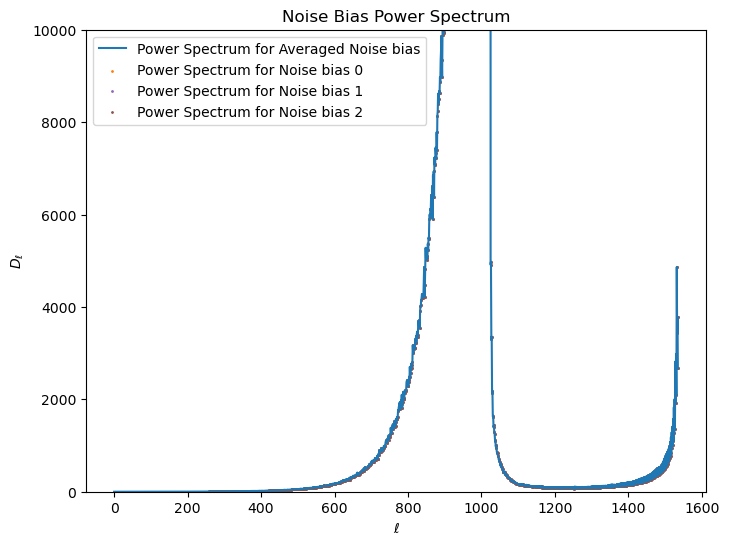

In [33]:
combined_power_spectrum_plot(ells,
                            [dl_noise_pred_avg],
                            dl_noise_preds,
                            ['Averaged Noise bias'],
                            [f'Noise bias {i}' for i in range(100)],
                            'Noise Bias Power Spectrum',
                            s=1)

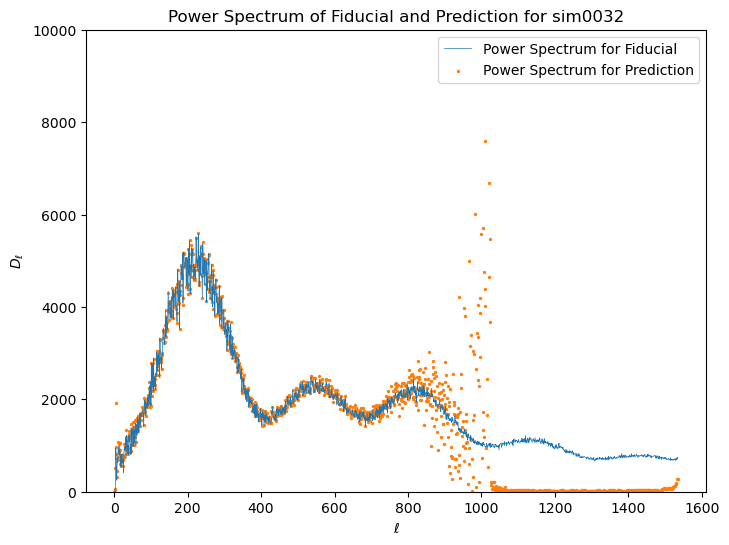

In [35]:
debiased_dl_pred = dl_pred_beam - dl_noise_pred_avg
combined_power_spectrum_plot(
    ells=ells,
    dls_line=[dl_fid],
    dls_scatter=[debiased_dl_pred],
    labels_line=['Fiducial'],
    labels_scatter=['Prediction'],
    title=f"Power Spectrum of Fiducial and Prediction for sim{sim_num:04d}",
    linewidth=0.5,
    alpha=1,
    s = 2
)


#### New noise

In [24]:
new_noise_res_dir = '/home/yunan/pyilc/output/new_noise_test/' 

In [25]:
new_cl_noise_preds = []
for i in range(100):
    noise_res_fn = new_noise_res_dir + f'sim{sim_num:03d}/CN_needletILCmap_component_CMB_noise_res.fits'
    noise_res = hp.read_map(noise_res_fn) / 1e6
    noise_res = beam_deconvol(noise_res, beam, nside)
    noise_res_masked = apply_mask(noise_res, mask)
    cl_noise_res = compute_power_spectrum(noise_res_masked, ellmax, fsky = fsky)
    new_cl_noise_preds.append(cl_noise_res)

FileNotFoundError: [Errno 2] No such file or directory: '/home/yunan/pyilc/output/new_noise_test/sim032/CN_needletILCmap_component_CMB_noise_res.fits'

In [32]:
new_dl_noise_preds = []
for new_cl_noise_pred in new_cl_noise_preds:
    cl_noise_pred_beam = new_cl_noise_pred/ beam**2
    dl_noise_pred_beam = ells * (ells + 1) * cl_noise_pred_beam / 2 / np.pi
    new_dl_noise_preds.append(dl_noise_pred_beam)

In [33]:
new_dl_noise_pred_avg = np.mean(new_dl_noise_preds, axis=0)

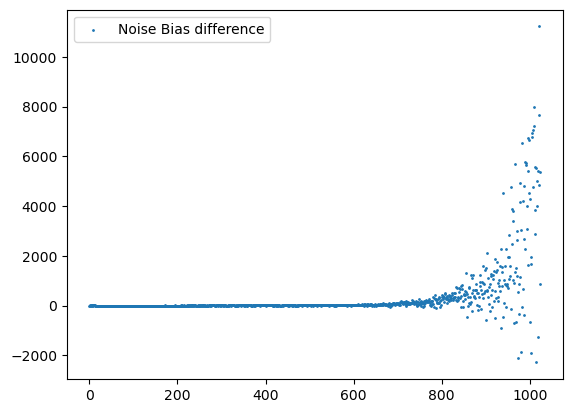

In [34]:
plt.scatter(ells, new_dl_noise_pred_avg - dl_noise_pred_avg, s = 1,label='Noise Bias difference')
plt.legend()
plt.show()

In [35]:
new_pred_path = '/shared/data/Datasets/I_512_1450/PyILC_CNILC/NILC_B_Predict/Test/sim0000/cmb_pred.fits'
new_cmb_pred = hp.read_map(new_pred_path)
new_cmb_pred_masked = apply_mask(new_cmb_pred, mask)
new_cl_pred = compute_power_spectrum(new_cmb_pred_masked, ellmax, fsky = fsky) 
new_cl_pred_beam = new_cl_pred/ beam**2
new_dl_pred_beam = ells * (ells + 1) * new_cl_pred_beam / 2 / np.pi


In [36]:
test_dl_pred_beam_noise = new_dl_pred_beam - new_dl_noise_pred_avg

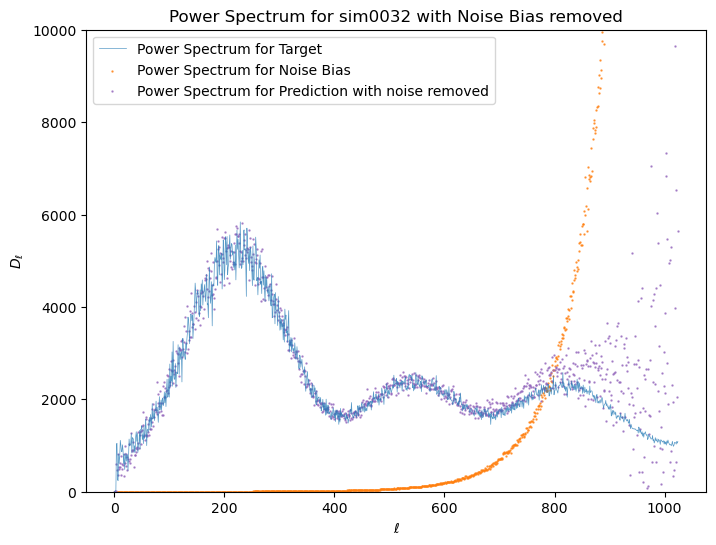

In [37]:
combined_power_spectrum_plot(ells,
                            [dl_fid],
                            [new_dl_noise_pred_avg, test_dl_pred_beam_noise],
                            ['Target'],
                            ['Noise Bias', 'Prediction with noise removed'],
                            f'Power Spectrum for sim{sim_num:04d} with Noise Bias removed',
                            linewidth=0.5,
                            alpha=0.75,
                            s=0.5)

In [61]:
test_dl_pred_beam_noise_combined = new_dl_pred_beam - new_dl_noise_pred_avg - dl_combined_fg_avg

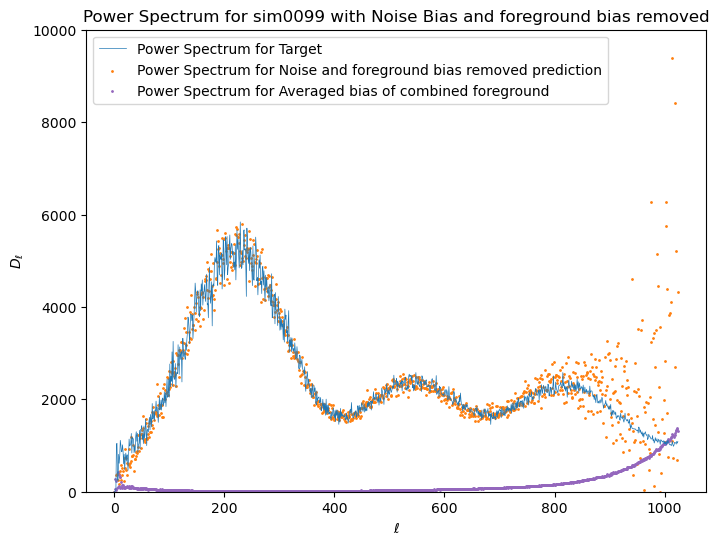

In [62]:
combined_power_spectrum_plot(ells,
                            [dl_fid],
                            [test_dl_pred_beam_noise_combined,dl_combined_fg_avg],
                            ['Target'],
                            ['Noise and foreground bias removed prediction', 'Averaged bias of combined foreground'],
                            f'Power Spectrum for sim{sim_num:04d} with Noise Bias and foreground bias removed',
                            linewidth=0.5,
                            alpha=1,
                            s=1)

## 5. Estimate bias introduced by foreground components

### (a) Load foreground weighted maps and apply mask

In [40]:
fg_working_dir = '/home/yunan/pyilc/output/foreground/combined/'

In [41]:
combined_fg_maps = []
for sim_num in range(100):
    fn = fg_working_dir + f'sim{sim_num:03d}/CN_needletILCmap_component_CMB_foreground_res.fits'
    map = hp.read_map(fn)
    map_masked = apply_mask(map, mask)
    combined_fg_maps.append(map_masked)

### (b) Calculate power spectrum and correct for fraction of sky

In [42]:
combined_fg_cls = []
for map in combined_fg_maps:
    cl = compute_power_spectrum(map, ellmax, fsky = fsky)
    combined_fg_cls.append(cl)

### (c) Deconvolve the common beam and normalize

In [43]:
dl_combined_fg = []
for cl in combined_fg_cls:
    cl_beam = cl / beam**2
    dl = normalize_cl(cl_beam)
    dl_combined_fg.append(dl)
dl_combined_fg_avg = np.mean(dl_combined_fg, axis=0)

### (d) Visualize

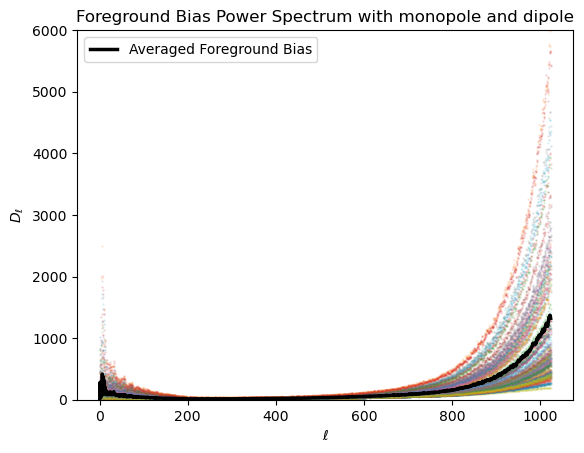

In [44]:
plt.plot(ells, dl_combined_fg_avg, label='Averaged Foreground Bias', c = 'black',linewidth=2.5, alpha=1)
for fg_dl in dl_combined_fg:
    plt.scatter(ells, fg_dl, s=0.5, alpha=0.15)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$D_{\ell}$')
plt.ylim(0, 6e3)
plt.title('Foreground Bias Power Spectrum with monopole and dipole')
plt.legend()
plt.show()

## 6. Remove noise bias

In [45]:
dl_pred_beam_noise = dl_pred_beam - dl_noise_pred_avg

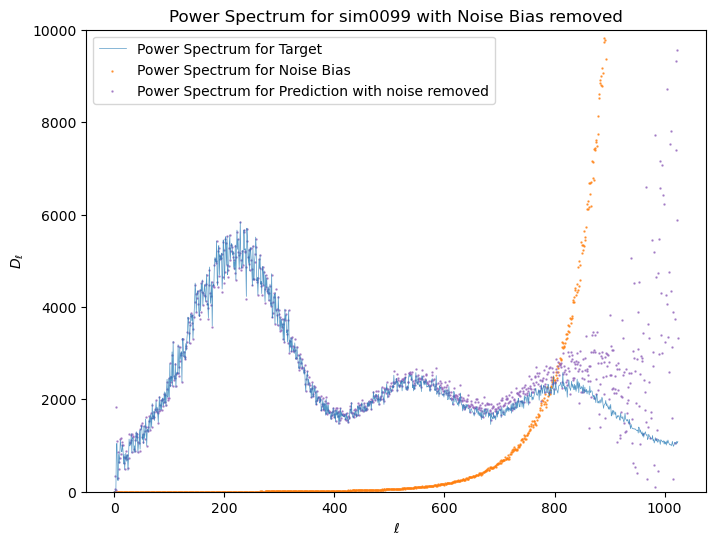

In [46]:
combined_power_spectrum_plot(ells,
                            [dl_fid],
                            [dl_noise_pred_avg, dl_pred_beam_noise],
                            ['Target'],
                            ['Noise Bias', 'Prediction with noise removed'],
                            f'Power Spectrum for sim{sim_num:04d} with Noise Bias removed',
                            linewidth=0.5,
                            alpha=0.75,
                            s=0.5)

In [47]:
new_dl_pred_beam_noise = dl_pred_beam - new_dl_noise_pred_avg

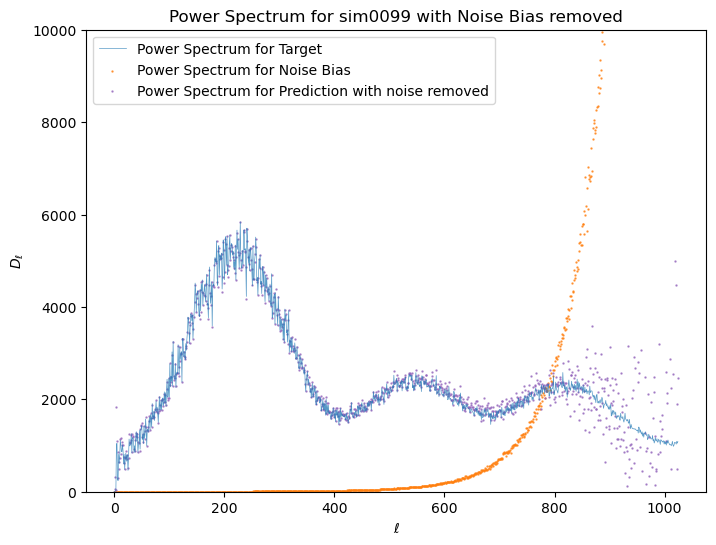

In [48]:
combined_power_spectrum_plot(ells,
                            [dl_fid],
                            [new_dl_noise_pred_avg, new_dl_pred_beam_noise],
                            ['Target'],
                            ['Noise Bias', 'Prediction with noise removed'],
                            f'Power Spectrum for sim{sim_num:04d} with Noise Bias removed',
                            linewidth=0.5,
                            alpha=0.75,
                            s=0.5)

## 7. Remove foreground components

In [49]:
bias_to_be_removed = dl_pred_beam_noise - dl_fid

In [50]:
bias_res = bias_to_be_removed - dl_combined_fg_avg

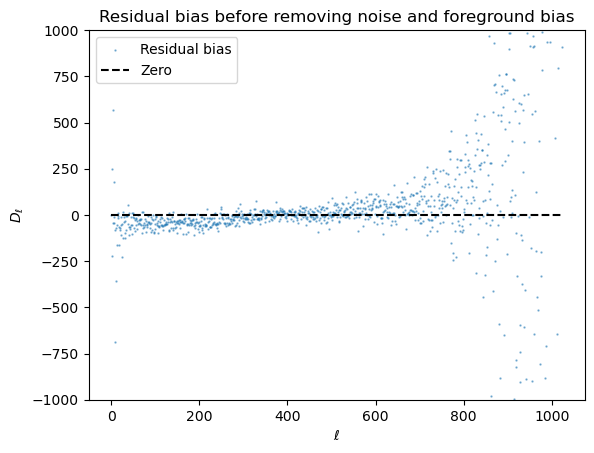

In [51]:
plt.scatter(ells, bias_res, label='Residual bias', s=0.5, alpha=0.5)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$D_{\ell}$')
plt.title('Residual bias before removing noise and foreground bias')
plt.ylim(-1e3, 1e3)
plt.hlines(0, 0, ells[-1], colors='black', linestyles='dashed', label='Zero', linewidth=1.5)
plt.legend()
plt.show()

In [52]:
dl_pred_beam_noise_combined = dl_pred_beam - dl_noise_pred_avg - dl_combined_fg_avg

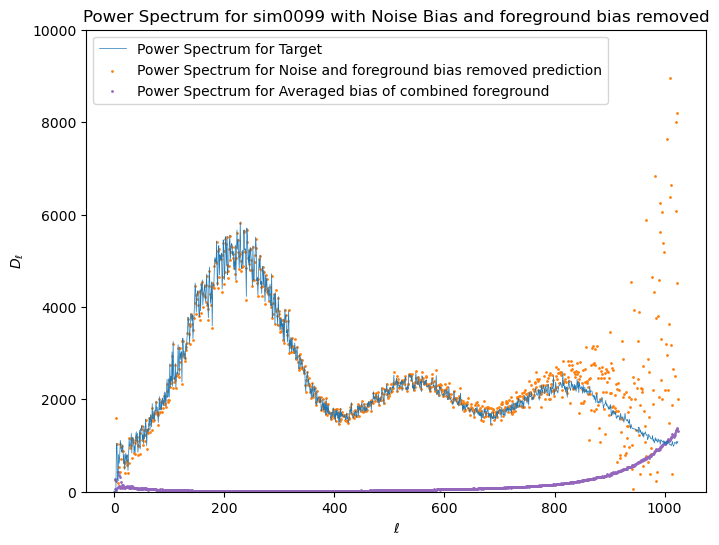

In [53]:
combined_power_spectrum_plot(ells,
                            [dl_fid],
                            [dl_pred_beam_noise_combined,dl_combined_fg_avg],
                            ['Target'],
                            ['Noise and foreground bias removed prediction', 'Averaged bias of combined foreground'],
                            f'Power Spectrum for sim{sim_num:04d} with Noise Bias and foreground bias removed',
                            linewidth=0.5,
                            alpha=1,
                            s=1)

In [54]:
new_bias_to_be_removed = new_dl_pred_beam_noise - dl_fid
new_bias_res = new_bias_to_be_removed - dl_combined_fg_avg

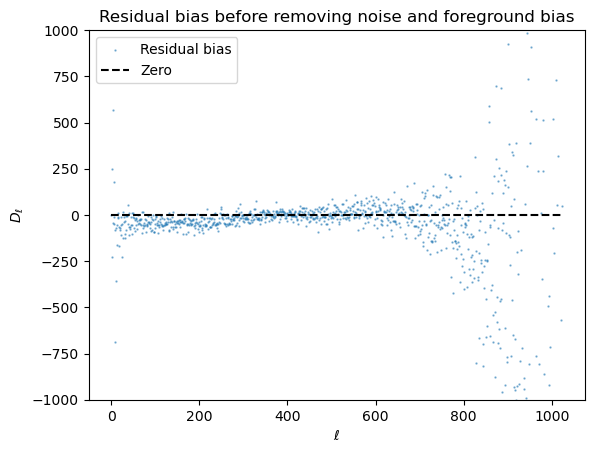

In [55]:
plt.scatter(ells, new_bias_res, label='Residual bias', s=0.5, alpha=0.5)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$D_{\ell}$')
plt.title('Residual bias before removing noise and foreground bias')
plt.ylim(-1e3, 1e3)
plt.hlines(0, 0, ells[-1], colors='black', linestyles='dashed', label='Zero', linewidth=1.5)
plt.legend()
plt.show()

In [56]:
new_dl_pred_beam_noise_combined = dl_pred_beam - new_dl_noise_pred_avg - dl_combined_fg_avg

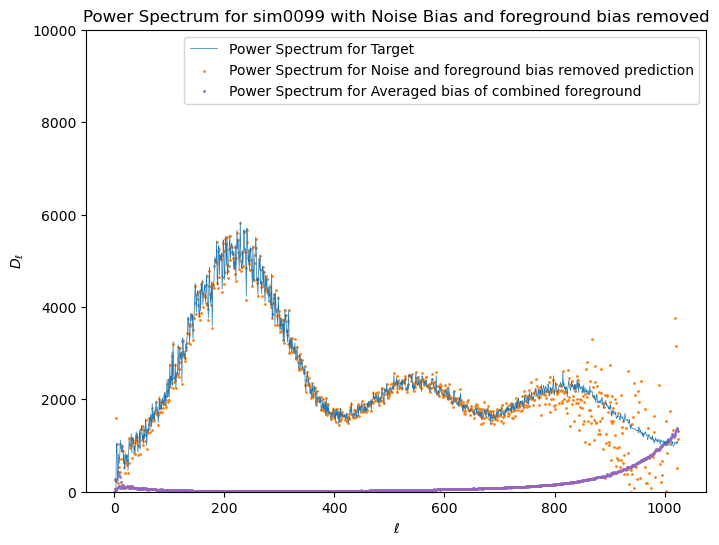

In [57]:
combined_power_spectrum_plot(ells,
                            [dl_fid],
                            [new_dl_pred_beam_noise_combined,dl_combined_fg_avg],
                            ['Target'],
                            ['Noise and foreground bias removed prediction', 'Averaged bias of combined foreground'],
                            f'Power Spectrum for sim{sim_num:04d} with Noise Bias and foreground bias removed',
                            linewidth=0.5,
                            alpha=1,
                            s=1)

### Boxcart convergence test

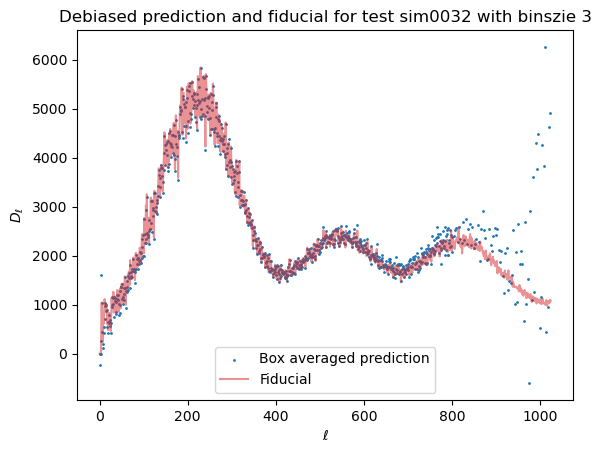

In [58]:
boxsize = 3
box_init = 800
ellmax = len(ells)  # Assuming ellmax is determined from the length of ells
box_num = (ellmax - box_init) // boxsize
box_cart_dl = []
ell_cart = list(np.copy(ells[:box_init]))
box_cart_dl = list(np.copy(dl_pred_beam_noise_combined[:box_init]))

for i in range(box_num):
    box_start = box_init + i * boxsize
    box_end = box_init + (i + 1) * boxsize
    box_ell = np.mean(ells[box_start:box_end])
    box_dl = np.mean(dl_pred_beam_noise_combined[box_start:box_end])
    box_cart_dl.append(box_dl)
    ell_cart.append(box_ell)

plt.scatter(ell_cart, box_cart_dl, s = 1 ,label='Box averaged prediction', color='tab:blue')
plt.plot(ells, dl_fid, label='Fiducial', color='tab:red', alpha = 0.5)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$D_{\ell}$')
plt.title(f'Debiased prediction and fiducial for test sim0032 with binszie {boxsize}')
plt.legend()
plt.show()
    

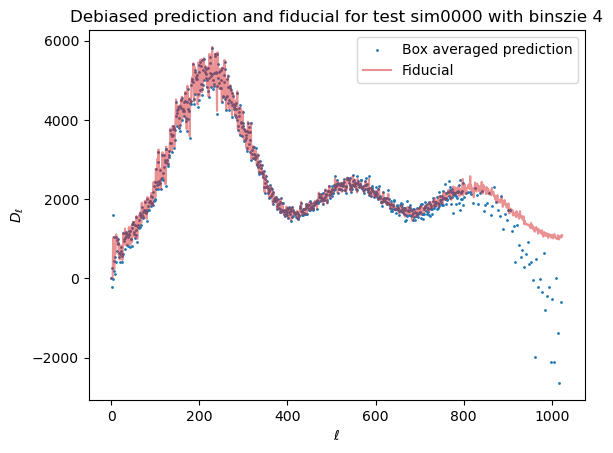

In [59]:
boxsize = 4
box_init = 800
ellmax = len(ells)  # Assuming ellmax is determined from the length of ells
box_num = (ellmax - box_init) // boxsize
box_cart_dl = []
ell_cart = list(np.copy(ells[:box_init]))
box_cart_dl = list(np.copy(new_dl_pred_beam_noise_combined[:box_init]))

for i in range(box_num):
    box_start = box_init + i * boxsize
    box_end = box_init + (i + 1) * boxsize
    box_ell = np.mean(ells[box_start:box_end])
    box_dl = np.mean(new_dl_pred_beam_noise_combined[box_start:box_end])
    box_cart_dl.append(box_dl)
    ell_cart.append(box_ell)

plt.scatter(ell_cart, box_cart_dl, s = 1 ,label='Box averaged prediction', color='tab:blue')
plt.plot(ells, dl_fid, label='Fiducial', color='tab:red', alpha = 0.5)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$D_{\ell}$')
plt.title(f'Debiased prediction and fiducial for test sim0000 with binszie {boxsize}')
plt.legend()
plt.show()

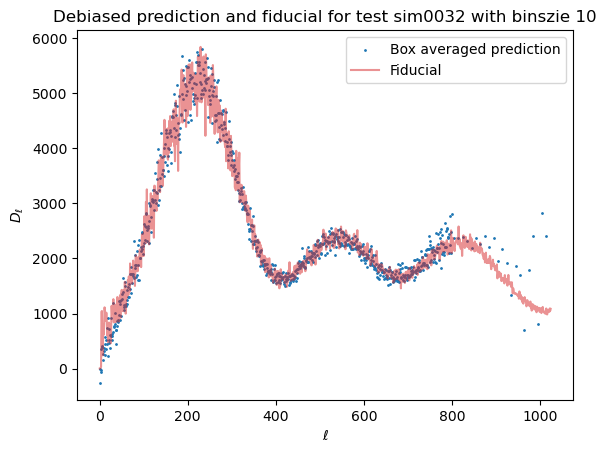

In [63]:
boxsize = 10
box_init = 800
ellmax = len(ells)  # Assuming ellmax is determined from the length of ells
box_num = (ellmax - box_init) // boxsize
box_cart_dl = []
ell_cart = list(np.copy(ells[:box_init]))
box_cart_dl = list(np.copy(test_dl_pred_beam_noise_combined[:box_init]))

for i in range(box_num):
    box_start = box_init + i * boxsize
    box_end = box_init + (i + 1) * boxsize
    box_ell = np.mean(ells[box_start:box_end])
    box_dl = np.mean(test_dl_pred_beam_noise_combined[box_start:box_end])
    box_cart_dl.append(box_dl)
    ell_cart.append(box_ell)

plt.scatter(ell_cart, box_cart_dl, s = 1 ,label='Box averaged prediction', color='tab:blue')
plt.plot(ells, dl_fid, label='Fiducial', color='tab:red', alpha = 0.5)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$D_{\ell}$')
plt.title(f'Debiased prediction and fiducial for test sim0032 with binszie {boxsize}')
plt.legend()
plt.show()

#### Outlier in the ensemble

In [64]:
highest_instance = np.argmax([np.max(arr) for arr in dl_combined_fg])
print(f'Highest instance: {highest_instance}')

Highest instance: 71


In [65]:
dl_pred_beam_noise_combined_test = dl_pred_beam - dl_noise_pred_avg - dl_combined_fg_avg
dl_pred_beam_noise_combined_test_max = dl_pred_beam - dl_noise_pred_avg - dl_combined_fg[highest_instance]

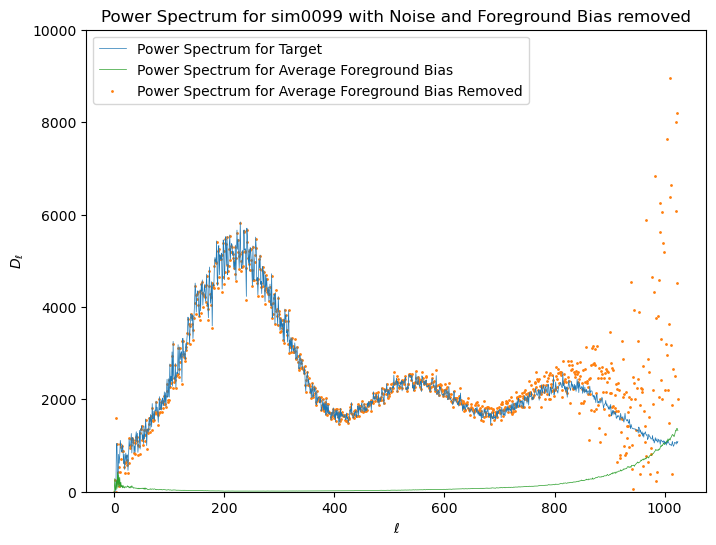

In [66]:
combined_power_spectrum_plot(ells,
                            [dl_fid, dl_combined_fg_avg],
                            [dl_pred_beam_noise_combined_test],
                            ['Target', 'Average Foreground Bias'],
                            ['Average Foreground Bias Removed'],
                            f'Power Spectrum for sim{sim_num:04d} with Noise and Foreground Bias removed',
                            linewidth=0.5,
                            alpha=1,
                            s=1)

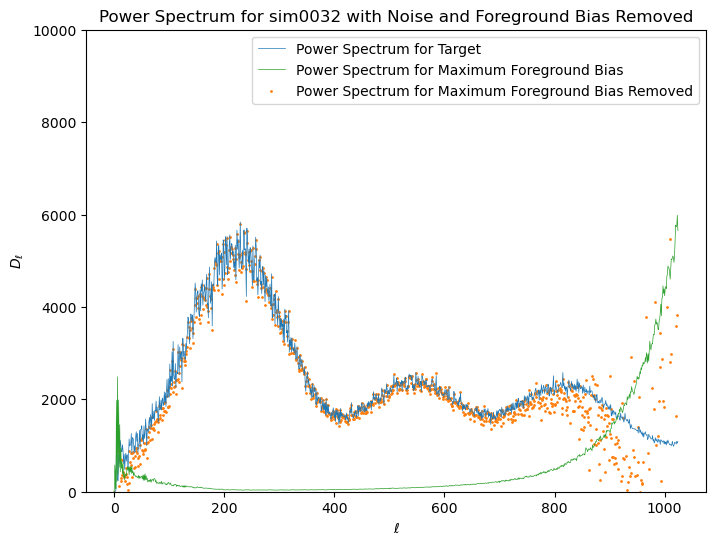

In [67]:
combined_power_spectrum_plot(ells,
                            [dl_fid, dl_combined_fg[highest_instance]],
                            [dl_pred_beam_noise_combined_test_max],
                            ['Target',  'Maximum Foreground Bias'],
                            ['Maximum Foreground Bias Removed'],
                            f'Power Spectrum for sim0032 with Noise and Foreground Bias Removed',
                            linewidth=0.5,
                            alpha=1,
                            s=1)

#### Namaster calculate mode coupling

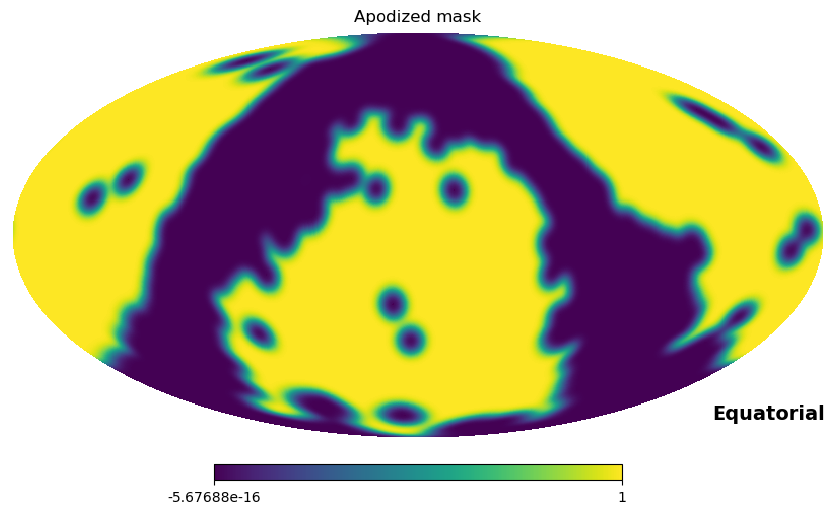

In [68]:
mask_apodized = nmt.mask_apodization(mask, 2.0, apotype='Smooth')
hp.mollview(mask_apodized, coord=['G', 'C'], title='Apodized mask')
plt.show()

In [69]:
f_0 = nmt.NmtField(mask_apodized, [cmb_fid])
p_0 = nmt.NmtField(mask_apodized, [cmb_pred])

In [70]:
b = nmt.NmtBin.from_nside_linear(nside, 1)

In [71]:
cl_f_00 = nmt.compute_full_master(f_0, f_0, b)
cl_p_00 = nmt.compute_full_master(p_0, p_0, b)

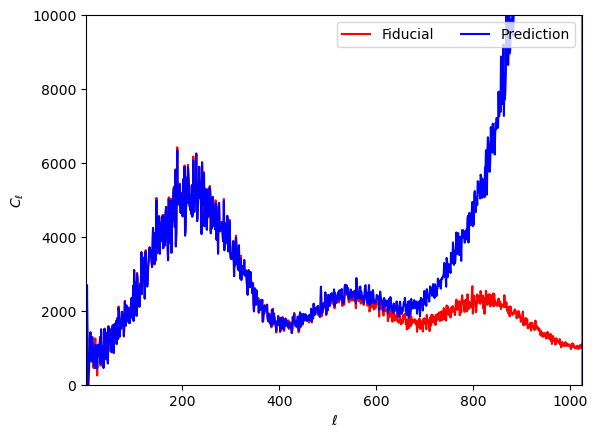

In [72]:
ell_arr = b.get_effective_ells()
dl_f_00 = cl_f_00[0] * ell_arr * (ell_arr + 1) / 2 / np.pi
dl_p_00 = cl_p_00[0] * ell_arr * (ell_arr + 1) / 2 / np.pi
dl_p_00_beam = dl_p_00[:1025]/beam**2
plt.plot(ell_arr, dl_f_00, 'r-', label='Fiducial')
plt.plot(ell_arr[:1025], dl_p_00_beam, 'b-', label='Prediction')
#plt.loglog()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')
plt.xlim(2, 1024)
plt.ylim(0, 1e4)
plt.legend(loc='upper right', ncol=2, labelspacing=0.1)
plt.show()

In [ ]:
cl_noise_preds = []
for i in range(100):
    noise_res_fn = noise_res_dir + f'sim{sim_num:03d}/CN_needletILCmap_component_CMB_noise_res.fits'
    noise_res = hp.read_map(noise_res_fn)
    noise_res = hp.remove_monopole(noise_res)
    noise_res = hp.remove_dipole(noise_res)
    noise_0 = nmt.NmtField(mask_apodized, [noise_res])
    cl_noise_res = nmt.compute_full_master(noise_0, noise_0, b)[0]
    cl_noise_preds.append(cl_noise_res)

In [51]:
dl_noise_preds_md = []
for cl_noise_pred in cl_noise_preds:
    dl_noise_pred = ell_arr * (ell_arr + 1) * cl_noise_pred / 2 / np.pi
    dl_noise_pred_beam = dl_noise_pred[:1025]/ beam**2
    dl_noise_preds_md.append(dl_noise_pred_beam)

: 

: 

In [52]:
dl_noise_pred_md_avg = np.mean(dl_noise_preds_md, axis=0)

: 

: 

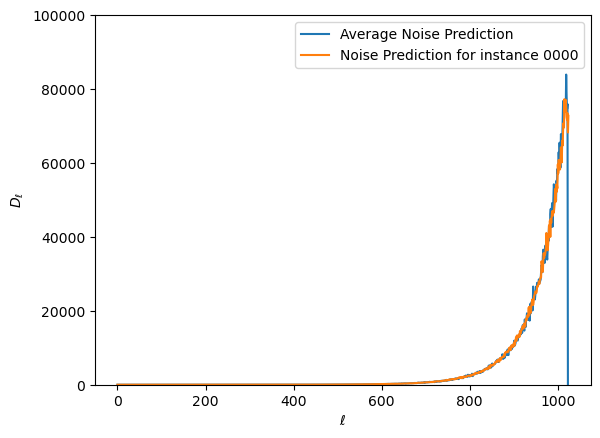

: 

: 

In [53]:
plt.plot(ells, dl_noise_pred_md_avg, label='Average Noise Prediction')
plt.plot(ells, dl_noise_pred_avg, label='Noise Prediction for instance 0000')
plt.xlabel('$\ell$')
plt.ylabel('$D_\ell$')
plt.ylim(0,1e5)
plt.legend()
plt.show()

In [54]:
combined_test = {}
for sim_num in range(100):
    fn = f'/home/yunan/pyilc/output/foreground/combined/sim{sim_num:03d}/CN_needletILCmap_component_CMB_foreground_res.fits'
    map = hp.read_map(fn)
    map = hp.remove_monopole(map)
    map = hp.remove_dipole(map)
    fg_00 = nmt.NmtField(mask_apodized, [map])
    cl_fg_00 = nmt.compute_full_master(fg_00, fg_00, b)[0]
    dl_fg_00 = cl_fg_00 * ell_arr * (ell_arr + 1) / 2 / np.pi
    dl_fg_00_beam = dl_fg_00[:1025]/beam**2
    combined_test[sim_num] = dl_fg_00_beam

: 

: 

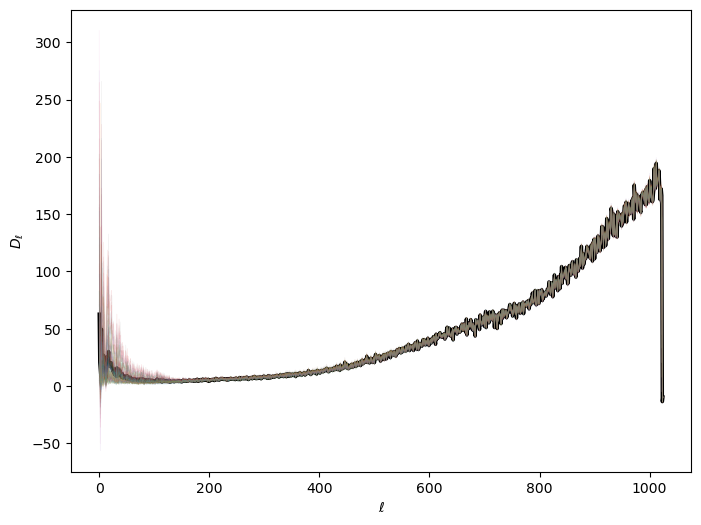

: 

: 

In [55]:
combined_test_avg = np.mean([combined_test[seed] for seed in combined_test], axis=0)

#plot_power_spectrum(ells, [dust_test_avg, combined_test_avg], ['Dust', 'Combined'], 'Power Spectrum of Dust and Combined Residuals', ymax=1e3)
plt.figure(figsize=(8, 6))
plt.plot(ells, combined_test_avg, label='Combined Bias', c = 'black',linewidth= 2.5, alpha = 1)
for sim_num in combined_test:
    plt.plot(ells, combined_test[sim_num], label=f'Combined Residual {sim_num}', linewidth=0.5, alpha = 0.1)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$D_{\ell}$')
#plt.legend()
plt.show()

#### Test for different foreground input

In [56]:
working_dir = '/home/yunan/pyilc/output/foreground/combined/'
fg_comp_test = {}

for seed in range(1,10):  # Range starts at 0 (by default) and goes to 9
    fg_comp_test[seed] = {}  # Initialize inner dictionary for each seed
    
    for sim_num in range(10):
        try:
            # Construct file name
            fn = working_dir + f'seed{seed:03d}/sim{sim_num:03d}/CN_needletILCmap_component_CMB_foreground_res.fits'
            
            # Read and process map
            map = hp.read_map(fn)
            map_masked = apply_mask(map, mask)
            cl = compute_power_spectrum(map_masked, ellmax, fsky=fsky)
            cl_beam = cl / beam**2
            dl = normalize_cl(cl_beam)
            
            # Store the result in the dictionary
            fg_comp_test[seed][sim_num] = dl
        
        except FileNotFoundError:
            print(f"File not found: {fn}, skipping this entry.")
            fg_comp_test[seed][sim_num] = None  # Indicate missing file

ValueError: operands could not be broadcast together with shapes (1026,) (1025,) 

: 

: 

In [84]:
dl_avg_fg = {}
for seed in range(1,10):
    dl_avg_fg[seed] = np.mean([fg_comp_test[seed][sim_num] for sim_num in range(10)], axis=0)

: 

: 

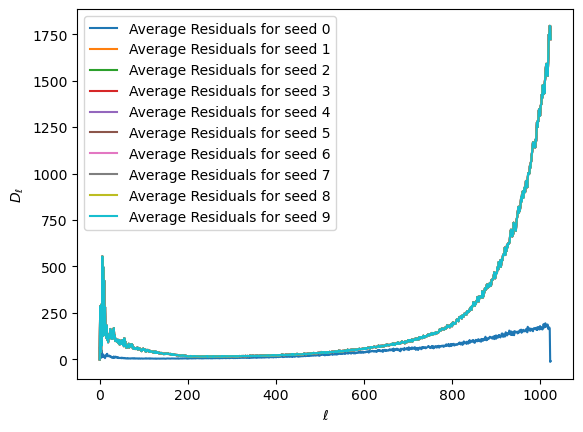

: 

: 

In [85]:
plt.plot(ells, combined_test_avg, label='Average Residuals for seed 0')
for seed in range(1,10):
    plt.plot(ells, dl_avg_fg[seed], label=f'Average Residuals for seed {seed}')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$D_{\ell}$')
plt.legend()
plt.show()

: 

: 